# <h1 align="center"><font color="red">Text Classification with Text Embeddings</font></h1>

<font color="pink">Senior Data Scientist.: Eddy Giusepe Chirinos Isidro</font>

Baseado no tutorial de [Shaw Talebi]()

# <font color="gree">Variáveis de ambiente</font>

In [1]:
import openai
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
#openai.api_key  = os.environ['OPENAI_API_KEY']
Eddy_key_openai  = os.environ['OPENAI_API_KEY']

from openai import OpenAI
client = OpenAI(api_key=Eddy_key_openai)

# <font color="gree">Baixando os dados do GitHub</font>

In [2]:
# Baixando os dados do GitHub:
#%cd /home/eddygiusepe/2_EddyGiusepe_Estudo/Learning_Class_in_Python/Embeddings_de_Texto/resumes

#!wget https://raw.githubusercontent.com/ShawhinT/YouTube-Blog/refs/heads/main/LLMs/text-embeddings/resumes/resumes_train.csv

# <font color="gree">Importando as bibliotecas necessárias e carregando os dados</font>

In [3]:
import openai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df_resume = pd.read_csv('./resumes/resumes_train.csv')
df_resume.head(2).style

,resume,role
0,"### John Doe --- #### Summary Detail-oriented Data Scientist with a strong foundation in statistics and programming. Proficient in analyzing complex datasets and developing machine learning models to drive business insights. Experienced in data visualization tools and techniques to effectively communicate findings to stakeholders. #### Professional Experience **Data Scientist**\ ABC Tech Company, Anytown, USA\ January 2018 - Present - Utilized Python and SQL to extract, clean, and manipulate large datasets for analysis - Developed predictive models to forecast sales trends, leading to a 15% increase in revenue - Collaborated with cross-functional teams to identify key business opportunities through data-driven insights #### Education **Master of Science in Data Science**\ XYZ University, Somewhere, USA\ Graduated: May 2017 **Bachelor of Science in Statistics**\ EFG College, Anywhere, USA\ Graduated: May 2015 #### Technical Skills - Programming Languages: Python, R, SQL - Data Visualization: Tableau, matplotlib, seaborn - Machine Learning: Regression, Classification, Clustering - Big Data Tools: Hadoop, Spark #### Certifications - Certified Data Scientist (CDS) - AWS Certified Solutions Architect - Associate #### Awards and Honors - Dean's List, XYZ University - Data Science Excellence Award, ABC Tech Company",Data Scientist
1,"Creating a resume for a Data Scientist based on the provided information: --- **John Doe** **Summary:** Dynamic and results-driven Data Scientist with a strong background in statistical analysis, machine learning, and data visualization. Experienced in developing predictive models and extracting valuable insights from complex data sets. Proven track record of solving real-world problems and driving business growth through data-driven decision-making. **Professional Experience:** - Data Scientist, Tech Solutions Inc., Anytown, USA - Developed and implemented machine learning algorithms to optimize marketing campaigns, resulting in a 20% increase in conversion rates. - Conducted exploratory data analysis to identify customer behavior patterns and provide strategic recommendations to improve user experience. - Data Analyst Intern, DataWorks Ltd., Anytown, USA - Assisted in the creation of data pipelines and ETL processes to streamline data processing and analysis. - Collaborated with cross-functional teams to analyze and visualize data for business intelligence reports. **Education:** - Master of Science in Data Science, University of Technology, Anytown, USA - Bachelor of Science in Statistics, Anytown University, Anytown, USA **Technical Skills:** - Programming Languages: Python, R, SQL - Machine Learning: Regression, Classification, Clustering - Data Visualization: Tableau, Matplotlib, Seaborn - Tools: Jupyter Notebook, Git, Pandas, NumPy **Certifications:** - Certified Data Scientist (CDS) - Data Science Institute **Awards and Honors:** - Dean's List for Academic Excellence, University of Technology --- This resume is a representation of a fictional Data Scientist named John Doe based on the provided input. Feel free to let me know if you need any specific adjustments or further details.",Data Scientist


In [4]:
df_resume.shape

(100, 2)

In [5]:
df_resume.value_counts('role')

role
Data Scientist                                                  40
Data Engineer                                                   20
Machine Learning Engineer                                       20
AI Consultant                                                   10
Data Entrepreneur                                                5
Generate a random resume, you decide the roles and industry.     5
Name: count, dtype: int64

# <font color="gree">Gerando Embeddings com OpenAI</font>

In [6]:
# def generate_embeddings(text):    
#     # Usando os Embeddings da OpenAI:
#     response = client.embeddings.create(
#         input=text,
#         model="text-embedding-3-small" # "text-embedding-3-small"    ou    "text-embedding-3-large"
#     )
    
#     # Retornas os Embeddings:
#     return response.data[0].embedding


def generate_embeddings(text):    
    # make api call:
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    
    # return text embedding
    return response.data

In [7]:
# generate embeddings
text_embeddings = generate_embeddings(df_resume['resume'])
# extract embeddings
text_embedding_list = [text_embeddings[i].embedding for i in range(len(text_embeddings))]

In [8]:
len(text_embedding_list)

100

In [9]:
len(text_embedding_list[0])


1536

# <font color="gree">Armazenando os Embeddings no DataFrame</font>

In [10]:
# define df column names
column_names = ["embedding_" + str(i) for i in range(len(text_embedding_list[0]))]

# store text embeddings in dataframe
df_train = pd.DataFrame(text_embedding_list, columns=column_names)

# create target variable
df_train['is_data_scientist'] = df_resume['role']=="Data Scientist"
df_train.to_csv('./resumes/embeddings_train.csv', index=False)
df_train.head()


,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1527,embedding_1528,embedding_1529,embedding_1530,embedding_1531,embedding_1532,embedding_1533,embedding_1534,embedding_1535,is_data_scientist
0,0.011923,0.010732,0.044013,0.023081,0.034455,0.000153,-0.020562,0.034800,-0.023785,-0.000629,...,0.043321,-0.029885,0.016449,0.001582,0.017499,0.010769,-0.037295,0.011022,0.001667,True
1,0.005887,0.030654,0.032117,-0.006901,0.008575,-0.034895,-0.015005,0.053421,-0.018737,0.012431,...,0.020039,-0.010435,0.012983,-0.008693,-0.003131,0.004374,-0.025161,0.033382,0.003277,True
2,0.008211,0.016624,0.029623,0.011863,0.014980,-0.028498,-0.011717,0.048397,-0.035791,0.019032,...,0.019437,0.000441,0.018672,0.001213,-0.001257,0.004882,-0.022735,0.022960,0.004629,True
3,0.000980,0.022212,0.049778,0.009431,0.015012,-0.034424,-0.012995,0.058286,-0.031759,0.034229,...,0.020476,-0.012872,0.025500,-0.002258,0.012567,0.000316,-0.032371,0.030463,0.008802,True
4,0.019266,0.003695,0.035332,0.021370,0.037020,-0.022668,-0.023764,0.061641,-0.019442,-0.005267,...,0.023764,-0.006754,0.031400,0.008064,0.017729,0.024810,-0.041002,0.031274,0.000356,True


In [11]:
df_train.value_counts('is_data_scientist')

is_data_scientist
False    60
True     40
Name: count, dtype: int64

In [12]:
df_train.shape

(100, 1537)

# <font color="gree">Visualizando embeddings com PCA</font>

In [13]:
# Dividir variáveis ​​por preditores e alvo:
X = df_train.iloc[:,:-1] # Seleciona todas as colunas exceto a última --> X = df_train.drop(columns=['is_data_scientist'])
y = df_train.iloc[:,-1] # Seleciona apenas a última coluna --> y = df_train['is_data_scientist']

# Aplicar PCA aos preditores (ou seja, embeddings)
pca = PCA(n_components=2).fit(X)

print(pca.explained_variance_ratio_)

[0.13940306 0.11352927]


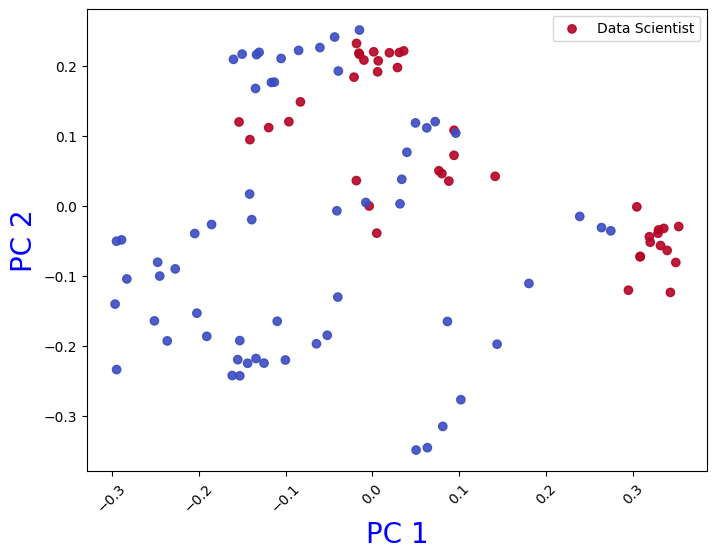

In [14]:
# Plotar dados ao longo dos componentes do PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=y, cmap='coolwarm', alpha=0.9) # edgecolor='k': Adiciona contornos pretos aos pontos, para melhorar a visibilidade.
plt.legend(["Data Scientist"])
plt.xticks(rotation = 45)
plt.xlabel("PC 1", fontsize=20, color='b')
plt.ylabel("PC 2", fontsize=20, color='b')
plt.show()

# <font color="gree">Visualizando embeddings com UMAP</font>

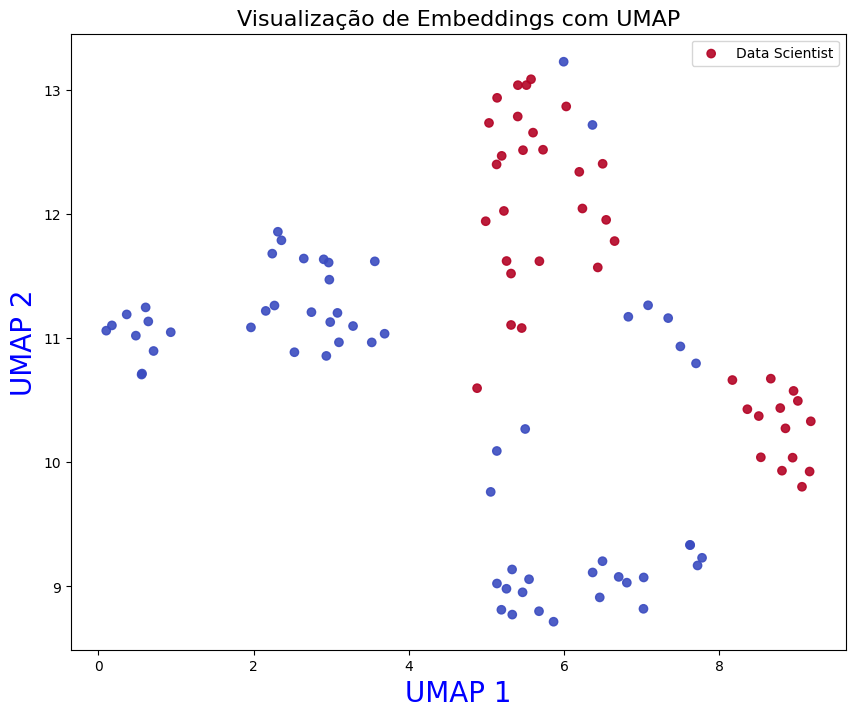

In [20]:
import umap.umap_ as umap

# Criar e ajustar o UMAP
#reducer = umap.UMAP(n_components=2, random_state=42)
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    #random_state=42,
    n_jobs=4
)
umap_embeddings = reducer.fit_transform(X)

# Criar a visualização
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
           c=y, cmap='coolwarm', alpha=0.9)
plt.legend(["Data Scientist"])
plt.xlabel("UMAP 1", fontsize=20, color='b')
plt.ylabel("UMAP 2", fontsize=20, color='b')
plt.title("Visualização de Embeddings com UMAP", fontsize=16)
plt.show()